# Making predictions

## Assignment

In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **housing prices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

Please submit a link your work notebook. This is not a graded checkpoint, but you should discuss your solutions with your mentor. Also, when you're done, compare your work to [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/6.solution_making_predictions.ipynb).

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine

# new to me
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
homes_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


In [3]:
# Preparing data for modeling about house prices 

# ojects holding columns
non_numeric_columns = homes_df.select_dtypes(['object']).columns
numeric_columns = homes_df.select_dtypes(['int64', 'float64']).columns

# dropping Missing data
homes_df = homes_df.drop(['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'lotfrontage'], axis=1)
homes_df = homes_df.dropna(axis=0)
numeric_columns = numeric_columns.drop(['id'])

FILL_LIST = []
for cols in homes_df[:]:
    if cols in numeric_columns:
        FILL_LIST.append(cols)

In [4]:
# Preprocessing
from scipy.stats.mstats import winsorize
homes_win = homes_df.copy()
for col in FILL_LIST:
    homes_win[col] = winsorize(homes_win[col], (.05, .14))

In [5]:
from sklearn import preprocessing

def cat_converter(df):
    for cols in df:
        if cols in non_numeric_columns:
            # Create a label (category) encoder object
            le = preprocessing.LabelEncoder()
            # Create a label (category) encoder object
            le.fit(df[cols])
            # Apply the fitted encoder to the pandas column
            df[cols] = le.transform(df[cols]) 
    return df
cat_converter(homes_win).head()

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,3,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,9550,1,0,3,0,0,0,...,0,0,0,0,0,2,2006,8,0,140000
4,5,60,3,13518,1,0,3,0,2,0,...,0,0,0,0,0,10,2008,8,4,250000


In [6]:
# selecting data and target
homes_mod2 = homes_win[['neighborhood', 'bsmtfinsf1', 'heatingqc', 'grlivarea', 'saleprice']]

data = homes_mod2.iloc[:, :-1]
target = homes_mod2['saleprice']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1070
The number of observations in test set is 268


In [8]:
# Adding a constant (all the time)
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     520.0
Date:                Wed, 11 Dec 2019   Prob (F-statistic):          1.30e-248
Time:                        20:16:17   Log-Likelihood:                -12551.
No. Observations:                1070   AIC:                         2.511e+04
Df Residuals:                    1065   BIC:                         2.514e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.121e+04   4459.838      9.240   

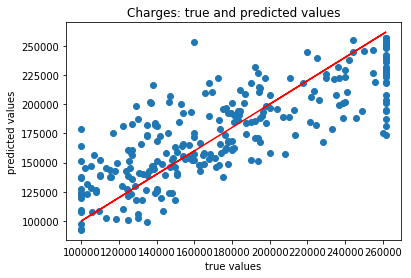

Mean absolute error of the prediction is: 24056.856861792385
Mean squared error of the prediction is: 937136850.2487041
Root mean squared error of the prediction is: 30612.690999791314
Mean absolute percentage error of the prediction is: 14.889954487793556


In [9]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))




In [10]:
# selecting data and target
homes_mod3 = homes_win[['lotarea', 'masvnrarea', 'bsmtfinsf1', 'totalbsmtsf',
                        'grlivarea', 'garagearea', 'wooddecksf', 'openporchsf',
                        'saleprice']]

data = homes_mod3.iloc[:, :-1]
target = homes_mod3['saleprice']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1070
The number of observations in test set is 268


In [12]:
# Adding a constant (all the time)
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     386.1
Date:                Wed, 11 Dec 2019   Prob (F-statistic):          6.18e-308
Time:                        20:16:17   Log-Likelihood:                -12401.
No. Observations:                1070   AIC:                         2.482e+04
Df Residuals:                    1061   BIC:                         2.486e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.729e+04   4147.421     -4.169      

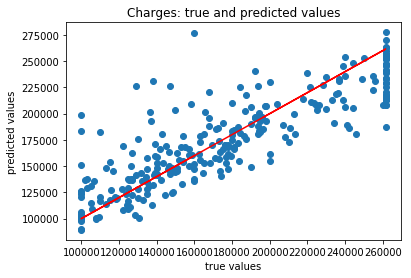

Mean absolute error of the prediction is: 19520.63973444582
Mean squared error of the prediction is: 750600519.5409917
Root mean squared error of the prediction is: 27397.0896180779
Mean absolute percentage error of the prediction is: 11.953791383030348


In [13]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))




By rearranging the features used to predict the target, I have reduced error and increased predictability. The second model is just an overall better fit with better predictability. 

For what we are doing here I believe this model is okay. There is always more you can do. 

# Biggest Takeaway 

* Lower values are desirable for all four metrics (MAE, MSE, RMSE, MAPE). The lower the value, the better the performance of the model.
* MAE, MSE, and RMSE are in the unit of the target variable but MAPE is unitless. So MAE, MSE, and RMSE are only useful if we compare different models that have the same target variable.
* MSE and RMSE penalize large errors more than the MAE and MAPE do. This means that MSE and RMSE are more useful when high error values are undesirable.
* For target values very close to zero, MAPE may provide a problematic picture of the performance as the ratio may go to very high values, and this may distort the average. It can also give division by zero errors if some values of the target are zero!
